<a href="https://colab.research.google.com/github/jaredlan1/getting_started_with_ML/blob/main/Hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torch matplotlib numpy

import os, math, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:

file_path = '/content/drive/MyDrive/Physics Informed ML/HW/kdata.txt'


ntraj_total = 2148  # number of trajectories
nt = 50  # number of time steps
ny = 7  # number of states

n_train =2048 #20148
n_test  = 100
seed = 0

rng = np.random.default_rng(seed)

tvec = np.linspace(0, 350, nt)

Y = np.loadtxt(file_path).reshape(ntraj_total, nt, ny).astype(np.float32)

# Split like the prompt: first 2048 train-candidate, last 100 test
Ytrain_full = Y[:2048]
Ytest = Y[2048:2048+n_test]

# Subsample training trajectories for fast iteration
assert n_train <= len(Ytrain_full)
train_idx = rng.choice(len(Ytrain_full), size=n_train, replace=False)
Ytrain = Ytrain_full[train_idx]

print("Ytrain:", Ytrain.shape, "Ytest:", Ytest.shape)


Ytrain: (2048, 50, 7) Ytest: (100, 50, 7)


In [ ]:
eps = 1e-8

mu=Ytrain.reshape(-1, ny).mean(axis=0)
std = Ytrain.reshape(-1,ny).std(axis=0) + eps

def normalize(A):
    return (A-mu)/ std

def denormalize(A):
    return A*std+mu

Ytrain_n = normalize(Ytrain)
Ytest_n = normalize(Ytest)

print("Train normalized mean (approx):", Ytrain_n.reshape(-1, ny).mean(axis=0))
print("Train normalized std  (approx):", Ytrain_n.reshape(-1, ny).std(axis=0))

Train normalized mean (approx): [-1.9077714e-05 -3.8507033e-06 -3.3960318e-05  3.8473681e-05
  1.8069846e-05  2.4760458e-05  9.3171993e-06]
Train normalized std  (approx): [1.0000019 1.0000073 1.0000019 1.0000086 1.0000073 0.9999975 1.0000008]


In [ ]:
Xtrain = torch.tensor(Ytrain_n, dtype=torch.float32) #batch_size,nt,ny
Xtest = torch.tensor(Ytest_n, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtrain), batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(TensorDataset(Xtest), batch_size=64, shuffle= False)

next(iter(train_loader))[0].shape

torch.Size([32, 50, 7])

In [ ]:
class MLP(nn.Module):
  def __init__(self,in_dim, out_dim, hidden=(128, 128), act=nn.ReLU):
      super().__init__()
      layers = []
      d = in_dim
      for h in hidden:
          layers += [nn.Linear(d,h), act()]
          d = h
      layers += [nn.Linear(d, out_dim)]
      self.net = nn.Sequential(*layers)

  def forward(self, x):
      return self.net(x)

class KoopmanAE(nn.Module):
      def __init__(self, x_dim=7, latent_dim=14, enc_hidden=(128, 128), dec_hidden=(128,128), dropout=0.0):
          super().__init__()
          self.encoder = MLP(x_dim, latent_dim, enc_hidden)
          self.decoder = MLP(latent_dim, x_dim, dec_hidden)
          self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
          self.K = nn.Linear(latent_dim, latent_dim, bias=False)

          with torch.no_grad():
              self.K.weight.zero_()
              self.K.weight += torch.eye(latent_dim)*0.98
              self.K.weight +=0.01* torch.randn_like(self.K.weight)


      def encode(self, x):
          return self.dropout(self.encoder(x))

      def decode(self,y):
          return self.decoder(y)

      def step_latent(self, y):
          return self.K(y)

      def rollout_latent(self, y0, steps):
          ys = [y0]
          y = y0
          for _ in range(steps-1):
              y = self.step_latent(y)
              ys.append(y)
          return torch.stack(ys, dim=1)

      def rollout_x(self, x0, steps):
          y0 = self.encode(x0)
          Yhat = self.rollout_latent(y0, steps)
          Xhat = self.decode(Yhat)
          return Xhat, Yhat






latent_dim = 8
enc_hidden = (128, 128)
dec_hidden = (128, 128)
dropout = 0


model = KoopmanAE(x_dim=ny, latent_dim=latent_dim, enc_hidden = enc_hidden, dec_hidden=dec_hidden, dropout=dropout).to(device)
print(model)

KoopmanAE(
  (encoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=7, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=8, bias=True)
    )
  )
  (decoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=7, bias=True)
    )
  )
  (dropout): Identity()
  (K): Linear(in_features=8, out_features=8, bias=False)
)


In [ ]:
mse = nn.MSELoss()

def compute_losses(model, Xtraj):
    B, T, _ = Xtraj.shape
    x0 = Xtraj[:, 0, :]
    y0 = model.encode(x0)

    Ypred = model. rollout_latent(y0, T)
    Xpred = model.decode(Ypred)

    Ytrue = model.encode(Xtraj.reshape(B*T, ny)).reshape(B, T, -1)

    L_recon = mse(Xpred, Xtraj)
    L_lin = mse(Ypred, Ytrue)
    L_pred = mse(Xpred, Xtraj)

    return L_recon, L_lin, L_pred

In [ ]:
lr = 1e-3
weight_decay =1e-6
pretrain_epochs = 50
train_epochs = 200
alpha_recon = 1.0
alpha_pred  = 1.0
alpha_lin   = 1.0
grad_clip = 1.0

opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def run_epoch(model, loader, train=True, phase='full'):
    model.train(train)
    tot = {'loss':0.0, 'recon':0.0, 'lin':0.0, 'pred':0.0}
    n= 0
    for(Xtraj,) in loader:
        Xtraj = Xtraj.to(device)
        with torch.set_grad_enabled(train):
            L_recon, L_lin, L_pred = compute_losses(model, Xtraj)
            if phase == 'pretrain':
                loss = L_recon

            else:
                loss = alpha_recon*L_recon + alpha_lin*L_lin +alpha_pred*L_pred

            if train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                if grad_clip is not None:
                    nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                opt.step()


        bs = Xtraj.shape[0]
        tot['loss'] +=loss.item()*bs
        tot['recon'] += L_recon.item()*bs
        tot['lin'] +=L_lin.item()*bs
        tot['pred'] += L_pred.item()*bs
        n += bs

    for k in tot:
        tot[k] /= max(n,1)

    return tot

history = {'phase':[], 'epoch':[], 'train_loss':[], 'test_loss':[]}


# ---- Pretrain ----
for ep in range(pretrain_epochs):
    tr = run_epoch(model, train_loader, train=True,  phase="pretrain")
    te = run_epoch(model, test_loader,  train=False, phase="pretrain")
    history["phase"].append("pretrain")
    history["epoch"].append(ep)
    history["train_loss"].append(tr["loss"])
    history["test_loss"].append(te["loss"])
    if (ep+1) % 10 == 0:
        print(f"[pretrain {ep+1:4d}] train {tr['loss']:.4e} | test {te['loss']:.4e}")

# ---- Full loss ----
for ep in range(train_epochs):
    tr = run_epoch(model, train_loader, train=True,  phase="full")
    te = run_epoch(model, test_loader,  train=False, phase="full")
    history["phase"].append("full")
    history["epoch"].append(pretrain_epochs + ep)
    history["train_loss"].append(tr["loss"])
    history["test_loss"].append(te["loss"])
    if (ep+1) % 20 == 0:
        print(f"[full     {ep+1:4d}] train {tr['loss']:.4e} | test {te['loss']:.4e}")



[pretrain   10] train 5.8635e-01 | test 5.8189e-01
[pretrain   20] train 4.7902e-01 | test 4.6292e-01
[pretrain   30] train 4.1613e-01 | test 3.9147e-01
[pretrain   40] train 3.7866e-01 | test 3.6953e-01
[pretrain   50] train 3.7790e-01 | test 3.3776e-01
[full       20] train 6.6713e-01 | test 6.1922e-01
[full       40] train 5.2824e-01 | test 5.9603e-01
[full       60] train 4.6677e-01 | test 6.1286e-01
[full       80] train 4.0443e-01 | test 5.3307e-01
[full      100] train 3.4495e-01 | test 5.9240e-01
[full      120] train 3.0814e-01 | test 5.4728e-01
[full      140] train 2.9567e-01 | test 5.9361e-01
[full      160] train 2.8260e-01 | test 5.6388e-01
[full      180] train 2.4817e-01 | test 5.2916e-01
[full      200] train 2.4447e-01 | test 5.7123e-01


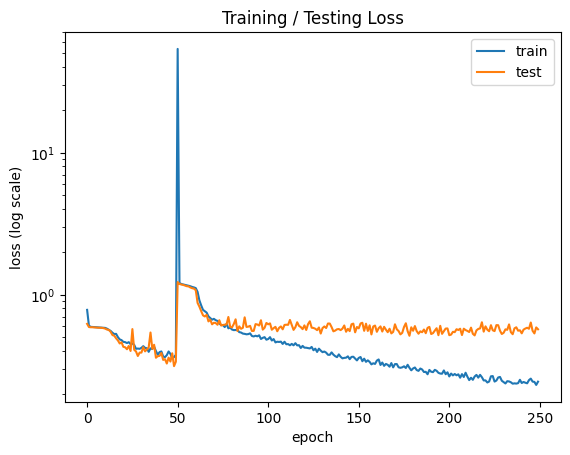

In [ ]:
epochs = np.array(history["epoch"])
train_loss = np.array(history["train_loss"])
test_loss  = np.array(history["test_loss"])

plt.figure()
plt.plot(epochs, train_loss, label="train")
plt.plot(epochs, test_loss, label="test")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss (log scale)")
plt.title("Training / Testing Loss")
plt.legend()
plt.show()

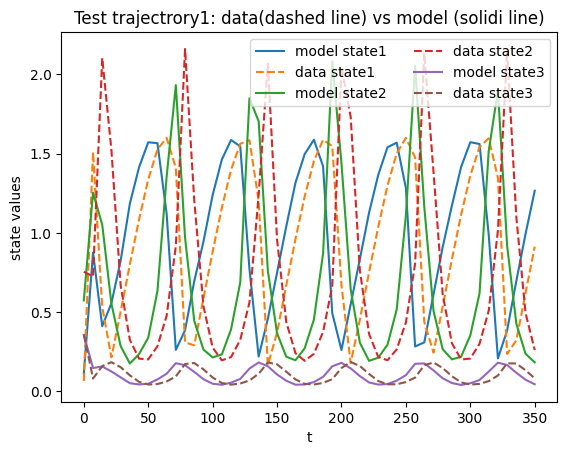

In [ ]:
torch.no_grad()
def predict_trajectory(model, Xtraj):
  x0 = Xtraj[0].to(device)
  Xhat, _ = model.rollout_x(x0[None,:], steps=Xtraj.shape[0])
  return Xhat[0].cpu()

x_true_n = Xtest[0]
x_hat_n = predict_trajectory(model, x_true_n)

x_true = denormalize(x_true_n.cpu().detach().numpy())
x_hat = denormalize(x_hat_n.cpu().detach().numpy())

plt.figure()
for i in range(3):
    plt.plot(tvec, x_hat[:, i], label=f'model state{i+1}')
    plt.plot(tvec, x_true[:, i], linestyle='--', label=f'data state{i+1}')
plt.xlabel('t')
plt.ylabel('state values')
plt.title('Test trajectrory1: data(dashed line) vs model (solidi line)')
plt.legend(ncol=2)
plt.show()

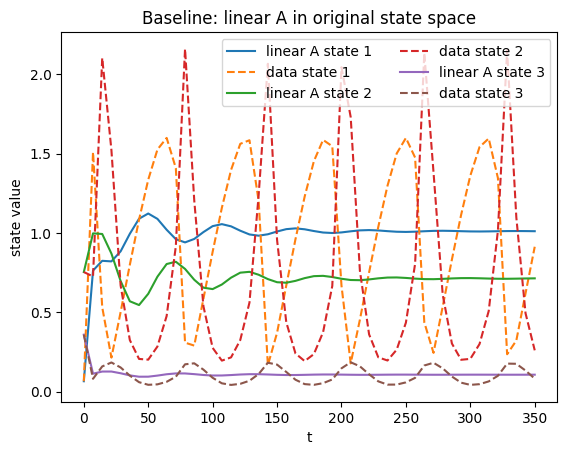

In [ ]:
def fit_linear_A(Ytrain_n):
    Xk  = Ytrain_n[:, :-1, :].reshape(-1, ny)
    Xkp = Ytrain_n[:, 1:,  :].reshape(-1, ny)
    A_T, *_ = np.linalg.lstsq(Xk, Xkp, rcond=None)  # Xk @ A_T ≈ Xkp
    return A_T.T

A = fit_linear_A(Ytrain_n)

def rollout_linear_A(A, x0, T):
    xs = [x0]
    x = x0
    for _ in range(T-1):
        x = A @ x
        xs.append(x)
    return np.stack(xs, axis=0)

x0 = x_true_n[0].cpu().numpy()
xA = rollout_linear_A(A, x0, nt)
xA_den = denormalize(xA)

plt.figure()
for i in range(3):
    plt.plot(tvec, xA_den[:, i], label=f"linear A state {i+1}")
    plt.plot(tvec, x_true[:, i], linestyle="--", label=f"data state {i+1}")
plt.xlabel("t")
plt.ylabel("state value")
plt.title("Baseline: linear A in original state space")
plt.legend(ncol=2)
plt.show()